<h1><center>Capstone Project - Driver Demand Prediction for Optimal Food Delivery Charges</center></h1>

## Problem Statement

1. This
project focuses on developing an effective predictive model that accurately estimates the time
it takes for orders to reach customre.
2. The aim is also to predict the demand for
delivery drivers in specific regions and times, by analyzing order requests, driver activity, an
relet d parameters, thereby optimizing delivery charges, ensuring consistency and minimini g
customer doffs..rs

<strong> Source for the dataset: </strong>https://www.kaggle.com/code/saloni1712/deliverontime-food-delivery-duration-predictor/

### Downloading dataset from Kaggle

In [1]:
# Step 1: Install Kaggle package
!pip install kaggle

# Step 2: Upload kaggle.json file
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

# Step 3: Set up Kaggle configuration
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
username = 'gauravmalik26'
!kaggle datasets list -s {username}

ref                                  title                  size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------  ---------------------  ----  -------------------  -------------  ---------  ---------------  
gauravmalik26/food-delivery-dataset  Food Delivery Dataset   2MB  2022-10-01 05:16:18          11944        112  0.7647059        


In [3]:
# Step 4: Download the dataset
# Replace 'dataset-name' with the dataset's identifier from Kaggle
username = 'gauravmalik26'
dataset = 'food-delivery-dataset'

!kaggle datasets download -d {username}/{dataset}

# Step 5: Unzip the dataset
import zipfile
with zipfile.ZipFile(f"{dataset}.zip", 'r') as zip_ref:
    zip_ref.extractall('data')

# List files to verify extraction
import os
os.listdir('data')

Dataset URL: https://www.kaggle.com/datasets/gauravmalik26/food-delivery-dataset
License(s): other
  0% 0.00/1.95M [00:00<?, ?B/s]
100% 1.95M/1.95M [00:00<00:00, 140MB/s]


['Sample_Submission.csv', 'test.csv', 'train.csv']

### Installing and importing libraries

In [4]:
!pip install "dask[distributed]" --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.5 MB/s eta 0:00:00


In [5]:
import dask

dask.config.set({"dataframe.backend": "cudf"})

In [1204]:
import dask.dataframe as dd
import numpy as np
import pandas as pd
import seaborn as sns
import holidays
from matplotlib import pyplot as plt
import dask
from dask.distributed import Client
import time
import logging
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

### Reading the Dataset

In [1094]:
df = pd.read_csv('/content/data/train.csv')
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [1095]:
print("Shape of the Dataset :", df.shape)

Shape of the Dataset : (45593, 20)


In [1096]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [1097]:
# Check for outliers
col_stats_info = []
unique_cat_info = []

for col in df.columns:
    stats_dict = dict()
    cat_uniq_values_dict = dict()
    stats_dict['column_name'] = col
    stats_dict['samples_count'] = df[col].count()
    stats_dict['missing_val_count'] = df[col].isna().sum()
    if df[col].dtype != 'object':
        stats_dict['col_range'] = df[col].max() - df[col].min()
        stats_dict['max_value'] = df[col].max()
        stats_dict['min_value'] = df[col].min()
    else:
        stats_dict['col_range'] = np.nan
        stats_dict['modal_class'] = df[col].mode()[0]
        stats_dict['num_of_classes'] = df[col].nunique()
        cat_uniq_values_dict['column_name'] = col
        cat_uniq_values_dict['classes'] = df[col].unique()
    stats_dict['col_dtype'] = df[col].dtype

    col_stats_info.append(stats_dict)
    unique_cat_info.append(cat_uniq_values_dict)


stats_df = pd.DataFrame.from_dict(col_stats_info)
stats_df

,column_name,samples_count,missing_val_count,col_range,modal_class,num_of_classes,col_dtype,max_value,min_value
0,ID,45593,0,NaN,0x1000,45593.0,object,NaN,NaN
1,Delivery_person_ID,45593,0,NaN,JAPRES11DEL02,1320.0,object,NaN,NaN
2,Delivery_person_Age,45593,0,NaN,35,23.0,object,NaN,NaN
3,Delivery_person_Ratings,45593,0,NaN,4.8,29.0,object,NaN,NaN
4,Restaurant_latitude,45593,0,61.819619,NaN,NaN,float64,30.914057,-30.905562
5,Restaurant_longitude,45593,0,176.799669,NaN,NaN,float64,88.433452,-88.366217
6,Delivery_location_latitude,45593,0,31.044057,NaN,NaN,float64,31.054057,0.010000
7,Delivery_location_longitude,45593,0,88.553452,NaN,NaN,float64,88.563452,0.010000
8,Order_Date,45593,0,NaN,15-03-2022,44.0,object,NaN,NaN
9,Time_Orderd,45593,0,NaN,NaN,177.0,object,NaN,NaN


## **Data Pre-processing**

### 1. Converting all column names into lower case

In [1098]:
df.columns = [col.strip().lower() for col in df.columns]
df.rename(columns= {"weatherconditions": "weather_conditions", "time_taken(min)": "time_taken_in_mins"}, inplace=True)
df.head(2)

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33


### 2. Replacing the NaN string throughtout the dataframe with np.nan

In [1099]:
for col in df.columns:
    df[col] = df[col].replace(to_replace=r'.*NaN.*', value=np.nan, regex=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           45593 non-null  object 
 1   delivery_person_id           45593 non-null  object 
 2   delivery_person_age          43739 non-null  object 
 3   delivery_person_ratings      43685 non-null  object 
 4   restaurant_latitude          45593 non-null  float64
 5   restaurant_longitude         45593 non-null  float64
 6   delivery_location_latitude   45593 non-null  float64
 7   delivery_location_longitude  45593 non-null  float64
 8   order_date                   45593 non-null  object 
 9   time_orderd                  43862 non-null  object 
 10  time_order_picked            45593 non-null  object 
 11  weather_conditions           44977 non-null  object 
 12  road_traffic_density         44992 non-null  object 
 13  vehicle_conditio

In [1100]:
df.isna().sum()

,0
id,0
delivery_person_id,0
delivery_person_age,1854
delivery_person_ratings,1908
restaurant_latitude,0
restaurant_longitude,0
delivery_location_latitude,0
delivery_location_longitude,0
order_date,0
time_orderd,1731


### 3. Removing (mins) fromm the time_taken_in_mins column to get the value of time taken

In [1101]:
df['time_taken_in_mins'] = df['time_taken_in_mins'].apply(lambda x: x.split(' ')[1])
df.head(2)

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,33


### 4. Converting the datatypes of the columns to the appropriate types

In [1102]:
df['delivery_person_age'] = df['delivery_person_age'].astype('float64')
df['delivery_person_ratings'] = df['delivery_person_ratings'].astype('float64')
df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
df['order_date'] = pd.to_datetime(df['order_date'], format="%d-%m-%Y")
df['time_orderd'] = pd.to_datetime(df['time_orderd'], format='%H:%M:%S')
df['time_order_picked'] = pd.to_datetime(df['time_order_picked'], format='%H:%M:%S')
df['time_taken_in_mins'] = df['time_taken_in_mins'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           45593 non-null  object        
 1   delivery_person_id           45593 non-null  object        
 2   delivery_person_age          43739 non-null  float64       
 3   delivery_person_ratings      43685 non-null  float64       
 4   restaurant_latitude          45593 non-null  float64       
 5   restaurant_longitude         45593 non-null  float64       
 6   delivery_location_latitude   45593 non-null  float64       
 7   delivery_location_longitude  45593 non-null  float64       
 8   order_date                   45593 non-null  datetime64[ns]
 9   time_orderd                  43862 non-null  datetime64[ns]
 10  time_order_picked            45593 non-null  datetime64[ns]
 11  weather_conditions           44977 non-nu

### 5. Extracting Weather condition information from Weatherconditions column

In [1103]:
df['weather_conditions'] = df['weather_conditions'].apply(lambda x: x.split(' ')[1] if isinstance(x, str) and x else x)
df.head(2)

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33


### 6. Cleaning the latitude and longitude columns

In [1104]:
df.head(2)

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33


In [1105]:
geo_cols = ['restaurant_latitude', 'restaurant_longitude', 'delivery_location_latitude', 'delivery_location_longitude']
for col in geo_cols:
    df[col] = df[col].apply(lambda x: abs(x))

### 7. Checking the stats of the dataset

In [1106]:
# Check for outliers
col_stats_info = []
unique_cat_info = []

for col in df.columns:
    stats_dict = dict()
    cat_uniq_values_dict = dict()
    stats_dict['column_name'] = col
    stats_dict['samples_count'] = df[col].count()
    stats_dict['missing_val_count'] = df[col].isna().sum()
    if df[col].dtype != 'object':
        stats_dict['col_range'] = df[col].max() - df[col].min()
        stats_dict['max_value'] = df[col].max()
        stats_dict['min_value'] = df[col].min()
    else:
        stats_dict['col_range'] = np.nan
        stats_dict['modal_class'] = df[col].mode()[0]
        stats_dict['num_of_classes'] = df[col].nunique()
        cat_uniq_values_dict['column_name'] = col
        cat_uniq_values_dict['classes'] = df[col].unique()
    stats_dict['col_dtype'] = df[col].dtype

    col_stats_info.append(stats_dict)
    unique_cat_info.append(cat_uniq_values_dict)


stats_df = pd.DataFrame.from_dict(col_stats_info)
stats_df

,column_name,samples_count,missing_val_count,col_range,modal_class,num_of_classes,col_dtype,max_value,min_value
0,id,45593,0,NaN,0x1000,45593.0,object,NaN,NaN
1,delivery_person_id,45593,0,NaN,JAPRES11DEL02,1320.0,object,NaN,NaN
2,delivery_person_age,43739,1854,35.0,NaN,NaN,float64,50.0,15.0
3,delivery_person_ratings,43685,1908,5.0,NaN,NaN,float64,6.0,1.0
4,restaurant_latitude,45593,0,30.914057,NaN,NaN,float64,30.914057,0.0
5,restaurant_longitude,45593,0,88.433452,NaN,NaN,float64,88.433452,0.0
6,delivery_location_latitude,45593,0,31.044057,NaN,NaN,float64,31.054057,0.01
7,delivery_location_longitude,45593,0,88.553452,NaN,NaN,float64,88.563452,0.01
8,order_date,45593,0,54 days 00:00:00,NaN,NaN,datetime64[ns],2022-04-06 00:00:00,2022-02-11 00:00:00
9,time_orderd,43862,1731,0 days 23:55:00,NaN,NaN,datetime64[ns],1900-01-01 23:55:00,1900-01-01 00:00:00


In [1107]:
feature_wise_unique_categories = pd.DataFrame.from_dict(unique_cat_info).dropna()
feature_wise_unique_categories

,column_name,classes
0,id,"[0x4607 , 0xb379 , 0x5d6d , 0x7a6a , 0x70a2 , ..."
1,delivery_person_id,"[INDORES13DEL02 , BANGRES18DEL02 , BANGRES19DE..."
11,weather_conditions,"[Sunny, Stormy, Sandstorms, Cloudy, Fog, Windy..."
12,road_traffic_density,"[High , Jam , Low , Medium , nan]"
14,type_of_order,"[Snack , Drinks , Buffet , Meal ]"
15,type_of_vehicle,"[motorcycle , scooter , electric_scooter , bic..."
17,festival,"[No , Yes , nan]"
18,city,"[Urban , Metropolitian , Semi-Urban , nan]"


### Identifying categorical and numerical columns

In [1108]:
def categorize_columns(df, cat_threshold=10, car_threshold=30):


    categorical_cols = [col for col in df.columns if df[col].dtype == "O"]


    num_as_cat_cols = [col for col in df.columns if df[col].nunique() < cat_threshold and df[col].dtype != "O"]


    high_card_cat_cols = [col for col in df.columns if df[col].nunique() > car_threshold and df[col].dtype == "O"]

    categorical_cols = list(set(categorical_cols + num_as_cat_cols) - set(high_card_cat_cols))


    numerical_cols = [col for col in df.columns if df[col].dtype not in ["O", 'datetime64[ns]']]
    numerical_cols = list(set(numerical_cols) - set(num_as_cat_cols))


    binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]

    print(f"Variables: {df.shape[1]}")
    print(f'Categorical columns: {len(categorical_cols)}')
    print(f'Numerical columns: {len(numerical_cols)}')
    print(f'High cardinality categorical columns: {len(high_card_cat_cols)}')
    print(f'Numerical columns with few unique values: {len(num_as_cat_cols)}')
    print(f'Binary columns: {len(binary_cols)}')

    return categorical_cols, numerical_cols, high_card_cat_cols, binary_cols

result = categorize_columns(df)
cat_cols, num_cols, bin_cols = result[0], result[1], result[3]

Variables: 20
Categorical columns: 8
Numerical columns: 7
High cardinality categorical columns: 2
Numerical columns with few unique values: 2
Binary columns: 1


In [1109]:
print('Categorical columns: ', cat_cols)
print('Numeric columns: ', num_cols)
print('Binary columns: ', bin_cols)

Categorical columns:  ['type_of_vehicle', 'festival', 'multiple_deliveries', 'vehicle_condition', 'city', 'weather_conditions', 'road_traffic_density', 'type_of_order']
Numeric columns:  ['delivery_location_longitude', 'time_taken_in_mins', 'delivery_person_ratings', 'restaurant_longitude', 'delivery_location_latitude', 'restaurant_latitude', 'delivery_person_age']
Binary columns:  ['festival']


## **Feature Engineering and Handling Missing values**

In [1110]:
df.isna().sum()[df.isna().sum() > 0]

,0
delivery_person_age,1854
delivery_person_ratings,1908
time_orderd,1731
weather_conditions,616
road_traffic_density,601
multiple_deliveries,993
festival,228
city,1200


### 1. Drop columns that are not useful

In [1111]:
df.drop('id', axis=1, inplace=True)
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33


### 2. Extracting City names, Restaurant number, Driver number from Delivery_person_ID

In [1112]:
df['city_name'] = df['delivery_person_id'].apply(lambda x: x.split("RES")[0])
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG


In [1113]:
df['city_name'].unique()

array(['INDO', 'BANG', 'COIMB', 'CHEN', 'HYD', 'RANCHI', 'MYS', 'DEH',
       'KOC', 'PUNE', 'LUDH', 'KNP', 'MUM', 'KOL', 'JAP', 'SUR', 'GOA',
       'AURG', 'AGR', 'VAD', 'ALH', 'BHP'], dtype=object)

In [1114]:
city_prefixes = {
    "INDO": "Indore",
    "BANG": "Bangalore",
    "COIMB": "Coimbatore",
    "CHEN": "Chennai",
    "HYD": "Hyderabad",
    "RANCHI": "Ranchi",
    "MYS": "Mysore",
    "DEH": "Delhi",
    "KOC": "Kochi",
    "PUNE": "Pune",
    "LUDH": "Ludhiana",
    "KNP": "Kanpur",
    "MUM": "Mumbai",
    "KOL": "Kolkata",
    "JAP": "Jaipur",
    "SUR": "Surat",
    "GOA": "Goa",
    "AURG": "Aurangabad",
    "AGR": "Agra",
    "VAD": "Vadodra",
    "ALH": "Prayagraj",
    "BHP": "Bhopal"
}

In [1115]:
df['city_name'] = df['city_name'].replace(city_prefixes)
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore


In [1116]:
df['restaurant_id'] = df['delivery_person_id'].apply(lambda x: x.split("RES")[1].split("DEL")[0])
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name,restaurant_id
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore,13
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore,18


In [1117]:
df['driver_id'] = df['delivery_person_id'].apply(lambda x: x.split("RES")[1].split("DEL")[1])
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name,restaurant_id,driver_id
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore,13,02
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore,18,02


### 3. Handling the missing value of age column by imputing city-wise median age value

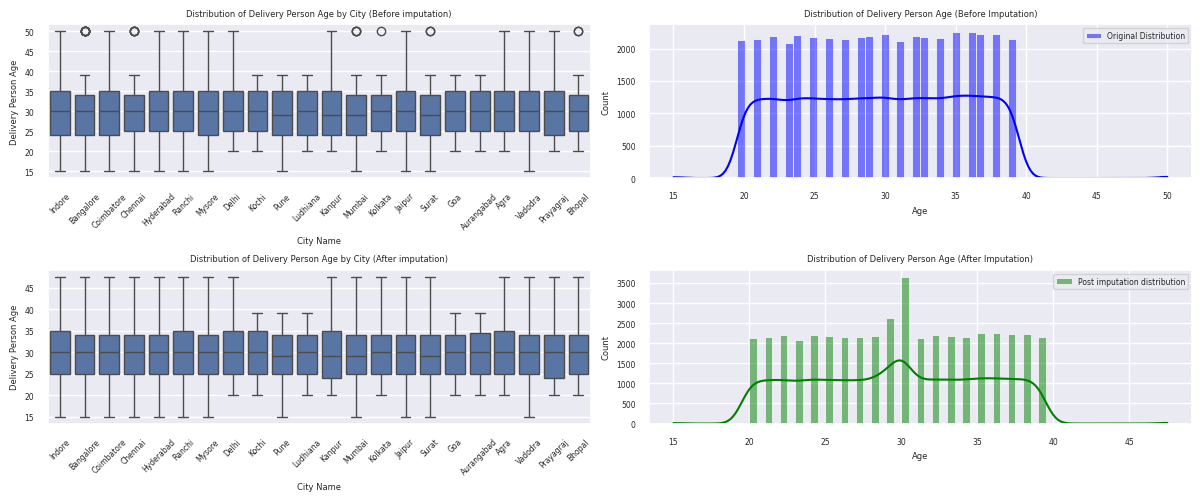

In [1118]:
# Before imputing
plt.figure(figsize=(12, 5))
sns.set(font_scale=0.5)

plt.subplot(2,2,1)
sns.boxplot(x='city_name', y='delivery_person_age', data=df)
plt.title('Distribution of Delivery Person Age by City (Before imputation)')
plt.xlabel('City Name')
plt.ylabel('Delivery Person Age')
plt.xticks(rotation=45)

# Plot the original distribution of 'Delivery_person_Age' before imputation
plt.subplot(2,2,2)
sns.histplot(df['delivery_person_age'].dropna(), kde=True, color='blue', label='Original Distribution')
plt.title('Distribution of Delivery Person Age (Before Imputation)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# Impute missing 'delivery_person_age' with the median age per city
df['delivery_person_age'] = df.groupby('city_name')['delivery_person_age'].transform(lambda x: x.fillna(x.median()))
df['delivery_person_age'] = df['delivery_person_age'].astype(int)

# Handling Outliers (for example, clipping the outliers based on IQR)
Q1 = df['delivery_person_age'].quantile(0.25)
Q3 = df['delivery_person_age'].quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
df['delivery_person_age'] = df['delivery_person_age'].clip(lower=lower_limit, upper=upper_limit)

# After imputing
plt.subplot(2,2,3)
sns.boxplot(x='city_name', y='delivery_person_age', data=df)
plt.title('Distribution of Delivery Person Age by City (After imputation)')
plt.xlabel('City Name')
plt.ylabel('Delivery Person Age')
plt.xticks(rotation=45)

# Plot the post imputation distribution of 'delivery_person_age' after imputation
plt.subplot(2,2,4)
sns.histplot(df['delivery_person_age'], kde=True, color='green', label='Post imputation distribution')
plt.title('Distribution of Delivery Person Age (After Imputation)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [1119]:
df.isna().sum()[df.isna().sum()>0]

,0
delivery_person_ratings,1908
time_orderd,1731
weather_conditions,616
road_traffic_density,601
multiple_deliveries,993
festival,228
city,1200


### 4. Handling the missing value of delivery_person_ratings column by imputing delivery_person_id's wise mode value

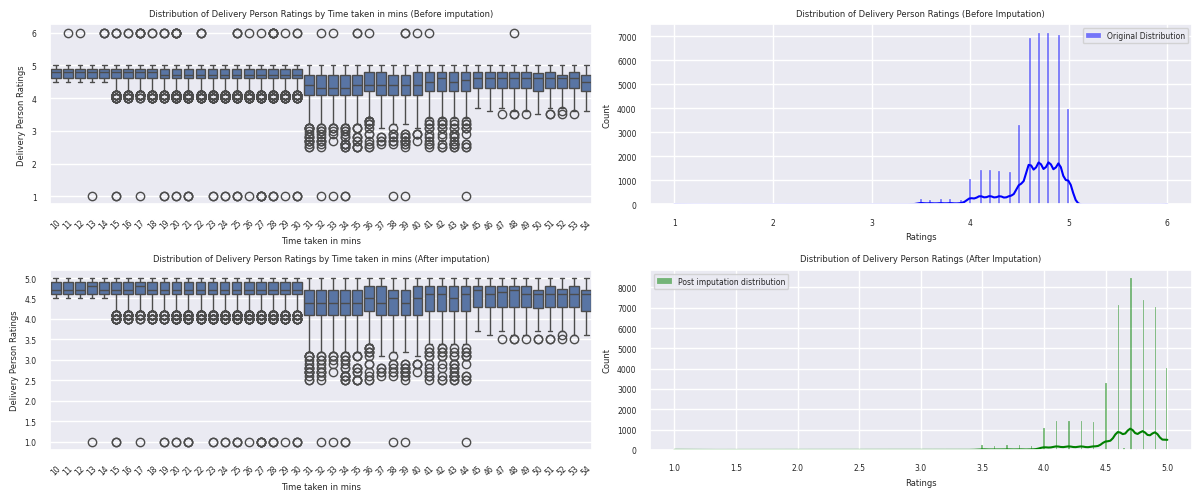

In [1120]:
# Before imputing
plt.figure(figsize=(12, 5))
sns.set(font_scale=0.5)

plt.subplot(2,2,1)
sns.boxplot(x='time_taken_in_mins', y='delivery_person_ratings', data=df)
plt.title('Distribution of Delivery Person Ratings by Time taken in mins (Before imputation)')
plt.xlabel('Time taken in mins')
plt.ylabel('Delivery Person Ratings')
plt.xticks(rotation=45)

# Plot the original distribution of 'delivery_person_ratings' before imputation
plt.subplot(2,2,2)
sns.histplot(df['delivery_person_ratings'].dropna(), kde=True, color='blue', label='Original Distribution')
plt.title('Distribution of Delivery Person Ratings (Before Imputation)')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.legend()

df['delivery_person_ratings'] = df.groupby(["delivery_person_id"])['delivery_person_ratings'].transform(lambda x: x.fillna(x.median()))
df["delivery_person_ratings"] = df["delivery_person_ratings"].replace(6, 5)
df["delivery_person_ratings"] = df["delivery_person_ratings"].replace(5.5, 5)

# After imputing
plt.subplot(2,2,3)
sns.boxplot(x='time_taken_in_mins', y='delivery_person_ratings', data=df)
plt.title('Distribution of Delivery Person Ratings by Time taken in mins (After imputation)')
plt.xlabel('Time taken in mins')
plt.ylabel('Delivery Person Ratings')
plt.xticks(rotation=45)

# Plot the post imputation distribution of 'delivery_person_age' after imputation
plt.subplot(2,2,4)
sns.histplot(df['delivery_person_ratings'], kde=True, color='green', label='Post imputation distribution')
plt.title('Distribution of Delivery Person Ratings (After Imputation)')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [1121]:
df.isna().sum()[df.isna().sum()>0]

,0
time_orderd,1731
weather_conditions,616
road_traffic_density,601
multiple_deliveries,993
festival,228
city,1200


### 5. Handling the missing value of road_traffic_density column by imputing city wise traffic density mode value

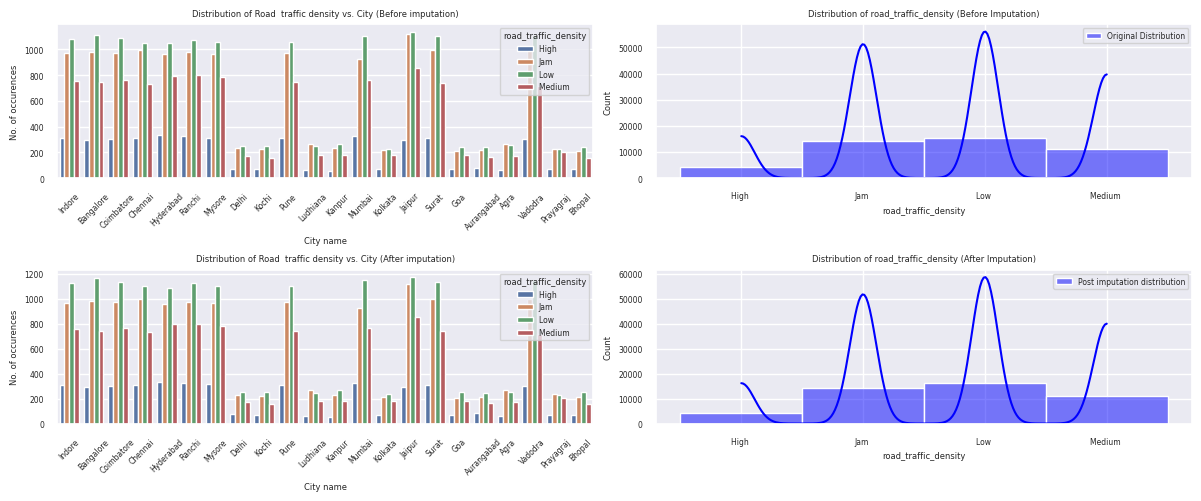

In [1122]:
# Before imputing
plt.figure(figsize=(12, 5))
sns.set(font_scale=0.5)

plt.subplot(2,2,1)
sns.countplot(x="city_name", hue="road_traffic_density", data=df)
plt.title('Distribution of Road  traffic density vs. City (Before imputation)')
plt.xlabel('City name')
plt.ylabel('No. of occurences')
plt.xticks(rotation=45)


# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(2,2,2)
sns.histplot(df['road_traffic_density'].dropna(), kde=True, color='blue', label='Original Distribution')
plt.title('Distribution of road_traffic_density (Before Imputation)')
plt.xlabel('road_traffic_density')
plt.ylabel('Count')
plt.legend()


df['road_traffic_density'] = df.groupby(["city_name"])['road_traffic_density'].transform(lambda x: x.fillna(x.mode()[0]))

plt.subplot(2,2,3)
sns.countplot(x="city_name", hue="road_traffic_density", data=df)
plt.title('Distribution of Road  traffic density vs. City (After imputation)')
plt.xlabel('City name')
plt.ylabel('No. of occurences')
plt.xticks(rotation=45)


# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(2,2,4)
sns.histplot(df['road_traffic_density'], kde=True, color='blue', label='Post imputation distribution')
plt.title('Distribution of road_traffic_density (After Imputation)')
plt.xlabel('road_traffic_density')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [1123]:
df.isna().sum()[df.isna().sum()>0]

,0
time_orderd,1731
weather_conditions,616
multiple_deliveries,993
festival,228
city,1200


### 7. Engineering a new feature - Month value of the when ordered

In [1124]:
df['month_ordered'] = df['order_date'].dt.month
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name,restaurant_id,driver_id,month_ordered
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore,13,02,3
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore,18,02,3


### 8. Handling missing values in weather_conditions column

In [1125]:
df['weather_conditions'].value_counts()

,count
weather_conditions,
Fog,7654
Stormy,7586
Cloudy,7536
Sandstorms,7495
Windy,7422
Sunny,7284


In [1126]:
weather_pivot = (
    df.groupby(["city_name", "weather_conditions"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
weather_pivot

weather_conditions,city_name,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
0,Agra,130,131,136,120,113,124
1,Aurangabad,109,120,122,129,97,121
2,Bangalore,514,527,534,515,523,526
3,Bhopal,116,123,125,110,108,101
4,Chennai,510,508,541,553,480,502
5,Coimbatore,500,555,493,546,505,528
6,Delhi,150,126,104,106,122,118
7,Goa,115,105,129,117,120,114
8,Hyderabad,496,520,522,532,540,533
9,Indore,526,544,489,567,505,486


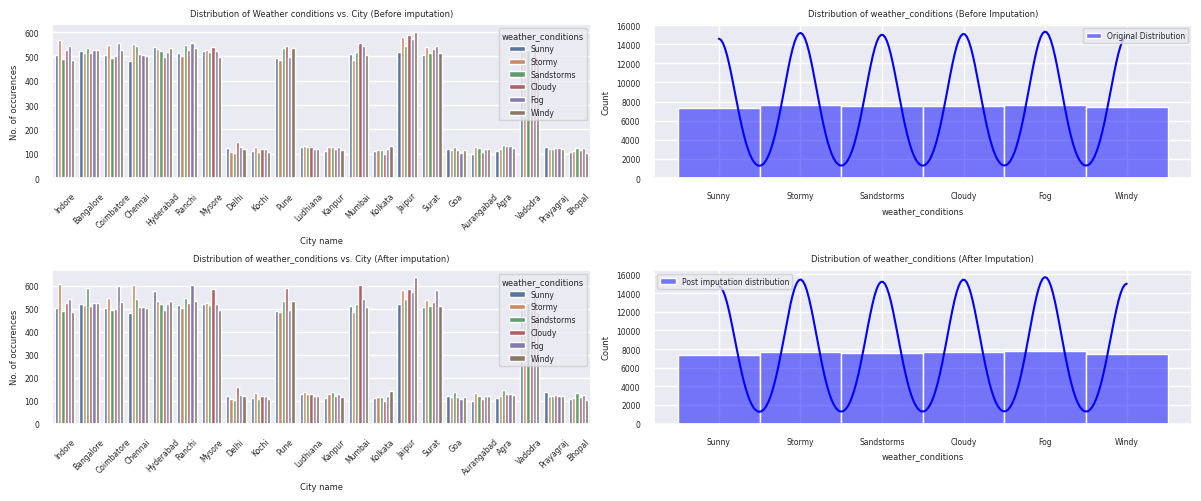

In [1127]:
# Before imputing
plt.figure(figsize=(12, 5))
sns.set(font_scale=0.5)

plt.subplot(2,2,1)
sns.countplot(x="city_name", hue="weather_conditions", data=df)
plt.title('Distribution of Weather conditions vs. City (Before imputation)')
plt.xlabel('City name')
plt.ylabel('No. of occurences')
plt.xticks(rotation=45)


# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(2,2,2)
sns.histplot(df['weather_conditions'].dropna(), kde=True, color='blue', label='Original Distribution')
plt.title('Distribution of weather_conditions (Before Imputation)')
plt.xlabel('weather_conditions')
plt.ylabel('Count')
plt.legend()

df['weather_conditions'] = df.groupby(["city_name"])['weather_conditions'].transform(lambda x: x.fillna(x.mode()[0]))

plt.subplot(2,2,3)
sns.countplot(x="city_name", hue="weather_conditions", data=df)
plt.title('Distribution of weather_conditions vs. City (After imputation)')
plt.xlabel('City name')
plt.ylabel('No. of occurences')
plt.xticks(rotation=45)


# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(2,2,4)
sns.histplot(df['weather_conditions'], kde=True, color='blue', label='Post imputation distribution')
plt.title('Distribution of weather_conditions (After Imputation)')
plt.xlabel('weather_conditions')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [1128]:
df.isna().sum()[df.isna().sum()>0]

,0
time_orderd,1731
multiple_deliveries,993
festival,228
city,1200


### 9. Handling missing values for festival column

In [1129]:
festival_pivot = (
    df.groupby(["city_name", "festival"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
festival_pivot

festival,city_name,No,Yes
0,Agra,747,15
1,Aurangabad,679,21
2,Bangalore,3121,55
3,Bhopal,676,10
4,Chennai,3068,61
5,Coimbatore,3091,66
6,Delhi,717,17
7,Goa,692,13
8,Hyderabad,3101,64
9,Indore,3071,66


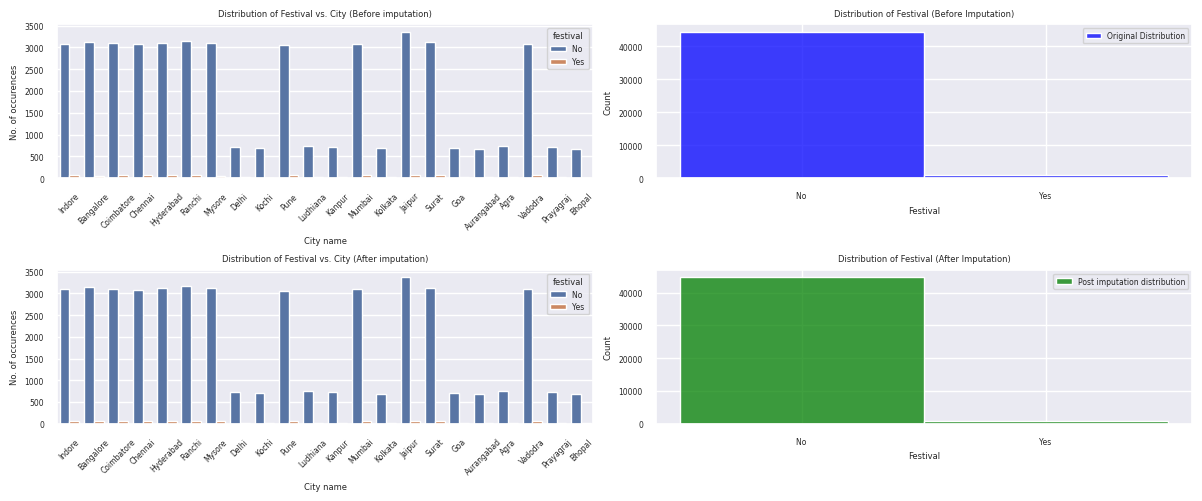

In [1130]:
# Before imputing
plt.figure(figsize=(12, 5))
sns.set(font_scale=0.5)

plt.subplot(2,2,1)
sns.countplot(x="city_name", hue="festival", data=df)
plt.title('Distribution of Festival vs. City (Before imputation)')
plt.xlabel('City name')
plt.ylabel('No. of occurences')
plt.xticks(rotation=45)


# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(2,2,2)
sns.histplot(df['festival'].dropna(), color='blue', label='Original Distribution')
plt.title('Distribution of Festival (Before Imputation)')
plt.xlabel('Festival')
plt.ylabel('Count')
plt.legend()

df['festival'] = df.groupby(["city_name", "order_date"])['festival'].transform(lambda x: x.fillna(x.mode()[0]))

plt.subplot(2,2,3)
sns.countplot(x="city_name", hue="festival", data=df)
plt.title('Distribution of Festival vs. City (After imputation)')
plt.xlabel('City name')
plt.ylabel('No. of occurences')
plt.xticks(rotation=45)


# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(2,2,4)
sns.histplot(df['festival'].dropna(), color='green', label='Post imputation distribution')
plt.title('Distribution of Festival (After Imputation)')
plt.xlabel('Festival')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [1131]:
df.isna().sum()[df.isna().sum()>0]

,0
time_orderd,1731
multiple_deliveries,993
city,1200


### 10. Handling missing values for city column

In [1132]:
city_pivot = (
    df.groupby(["city_name", "city"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
city_pivot

city,city_name,Metropolitian,Semi-Urban,Urban
0,Agra,571,3,171
1,Aurangabad,519,1,161
2,Bangalore,2361,11,723
3,Bhopal,547,2,129
4,Chennai,2371,10,682
5,Coimbatore,2387,15,674
6,Delhi,576,1,140
7,Goa,525,4,164
8,Hyderabad,2387,16,697
9,Indore,2381,9,689


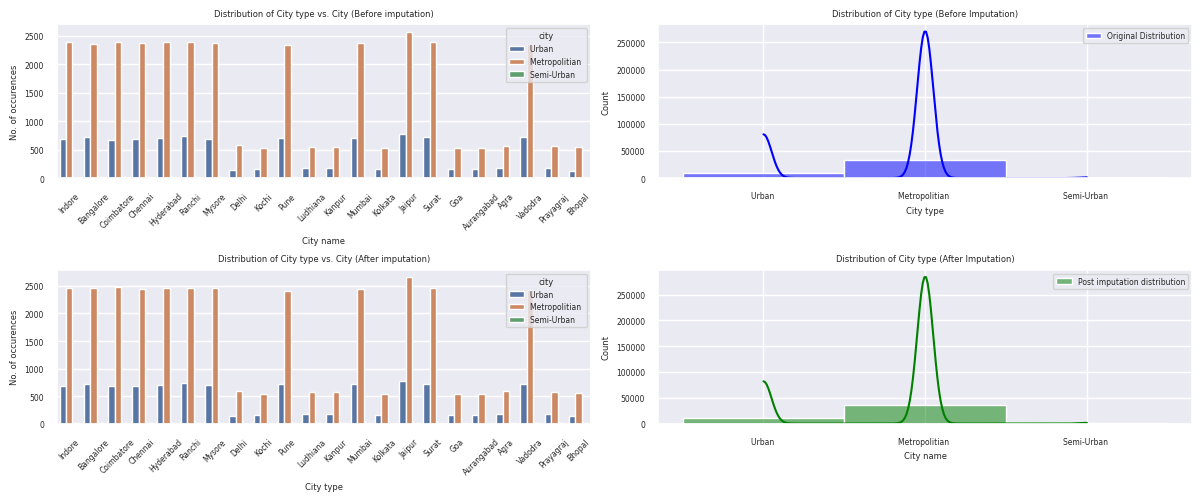

In [1133]:
# Before imputing
plt.figure(figsize=(12, 5))
sns.set(font_scale=0.5)

plt.subplot(2,2,1)
sns.countplot(x="city_name", hue="city", data=df)
plt.title('Distribution of City type vs. City (Before imputation)')
plt.xlabel('City name')
plt.ylabel('No. of occurences')
plt.xticks(rotation=45)


# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(2,2,2)
sns.histplot(df['city'].dropna(),kde=True, color='blue', label='Original Distribution')
plt.title('Distribution of City type (Before Imputation)')
plt.xlabel('City type')
plt.ylabel('Count')
plt.legend()

df['city'] = df.groupby(["city_name"])['city'].transform(lambda x: x.fillna(x.mode()[0]))

plt.subplot(2,2,3)
sns.countplot(x="city_name", hue="city", data=df)
plt.title('Distribution of City type vs. City (After imputation)')
plt.xlabel('City type')
plt.ylabel('No. of occurences')
plt.xticks(rotation=45)


# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(2,2,4)
sns.histplot(df['city'], kde=True, color='green', label='Post imputation distribution')
plt.title('Distribution of City type (After Imputation)')
plt.xlabel('City name')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [1134]:
df.isna().sum()[df.isna().sum()>0]

,0
time_orderd,1731
multiple_deliveries,993


### 11. Handling missing values for multiple deliveries column

In [1135]:
deliveries_pivot = (
    df.groupby(["city_name", "multiple_deliveries"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
deliveries_pivot

multiple_deliveries,city_name,0.0,1.0,2.0,3.0
0,Agra,227,483,34,7
1,Aurangabad,221,431,32,4
2,Bangalore,989,1995,124,24
3,Bhopal,225,406,43,4
4,Chennai,943,1948,153,25
5,Coimbatore,1004,1956,119,34
6,Delhi,233,439,43,6
7,Goa,235,416,31,6
8,Hyderabad,951,2003,145,26
9,Indore,976,1947,137,18


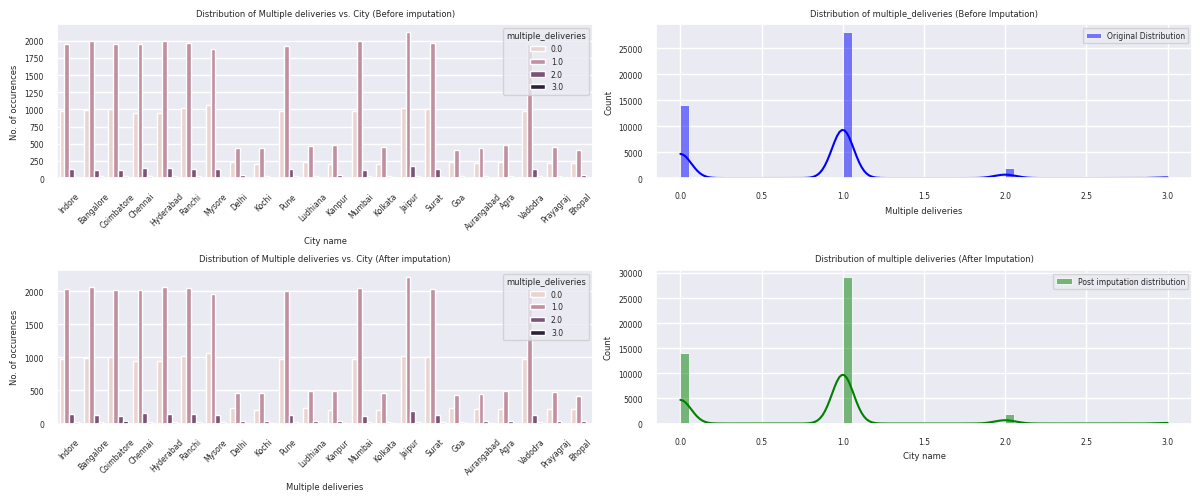

In [1136]:
# Before imputing
plt.figure(figsize=(12, 5))
sns.set(font_scale=0.5)

plt.subplot(2,2,1)
sns.countplot(x="city_name", hue="multiple_deliveries", data=df)
plt.title('Distribution of Multiple deliveries vs. City (Before imputation)')
plt.xlabel('City name')
plt.ylabel('No. of occurences')
plt.xticks(rotation=45)


# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(2,2,2)
sns.histplot(df['multiple_deliveries'].dropna(), kde=True, color='blue', label='Original Distribution')
plt.title('Distribution of multiple_deliveries (Before Imputation)')
plt.xlabel('Multiple deliveries')
plt.ylabel('Count')
plt.legend()

df['multiple_deliveries'] = df.groupby(["city_name"])['multiple_deliveries'].transform(lambda x: x.fillna(x.mode()[0]))

plt.subplot(2,2,3)
sns.countplot(x="city_name", hue="multiple_deliveries", data=df)
plt.title('Distribution of Multiple deliveries vs. City (After imputation)')
plt.xlabel('Multiple deliveries')
plt.ylabel('No. of occurences')
plt.xticks(rotation=45)


# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(2,2,4)
sns.histplot(df['multiple_deliveries'], kde=True, color='green', label='Post imputation distribution')
plt.title('Distribution of multiple deliveries (After Imputation)')
plt.xlabel('City name')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [1137]:
df.isna().sum()[df.isna().sum()>0]

,0
time_orderd,1731


### 12. Engineering a new feature - Order preparation time

In [1138]:
df['restaurant_id'] = df['restaurant_id'].astype(int)
df['driver_id'] = df['driver_id'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   delivery_person_id           45593 non-null  object        
 1   delivery_person_age          45593 non-null  float64       
 2   delivery_person_ratings      45593 non-null  float64       
 3   restaurant_latitude          45593 non-null  float64       
 4   restaurant_longitude         45593 non-null  float64       
 5   delivery_location_latitude   45593 non-null  float64       
 6   delivery_location_longitude  45593 non-null  float64       
 7   order_date                   45593 non-null  datetime64[ns]
 8   time_orderd                  43862 non-null  datetime64[ns]
 9   time_order_picked            45593 non-null  datetime64[ns]
 10  weather_conditions           45593 non-null  object        
 11  road_traffic_density         45593 non-nu

In [1139]:
def adjust_end_time(row):
    if row['time_order_picked'] < row['time_orderd']:
        return row['time_order_picked'] + pd.Timedelta(days=1)
    else:
        return row['time_order_picked']

df['time_order_picked'] = df.apply(adjust_end_time, axis=1)

In [1140]:
df['order_pick_time'] = (df['time_order_picked'] - df['time_orderd']).dt.total_seconds()/60
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name,restaurant_id,driver_id,month_ordered,order_pick_time
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore,13,2,3,15.0
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore,18,2,3,5.0


In [1141]:
df["order_pick_time"].value_counts()

,count
order_pick_time,
5.0,14703
15.0,14610
10.0,14549


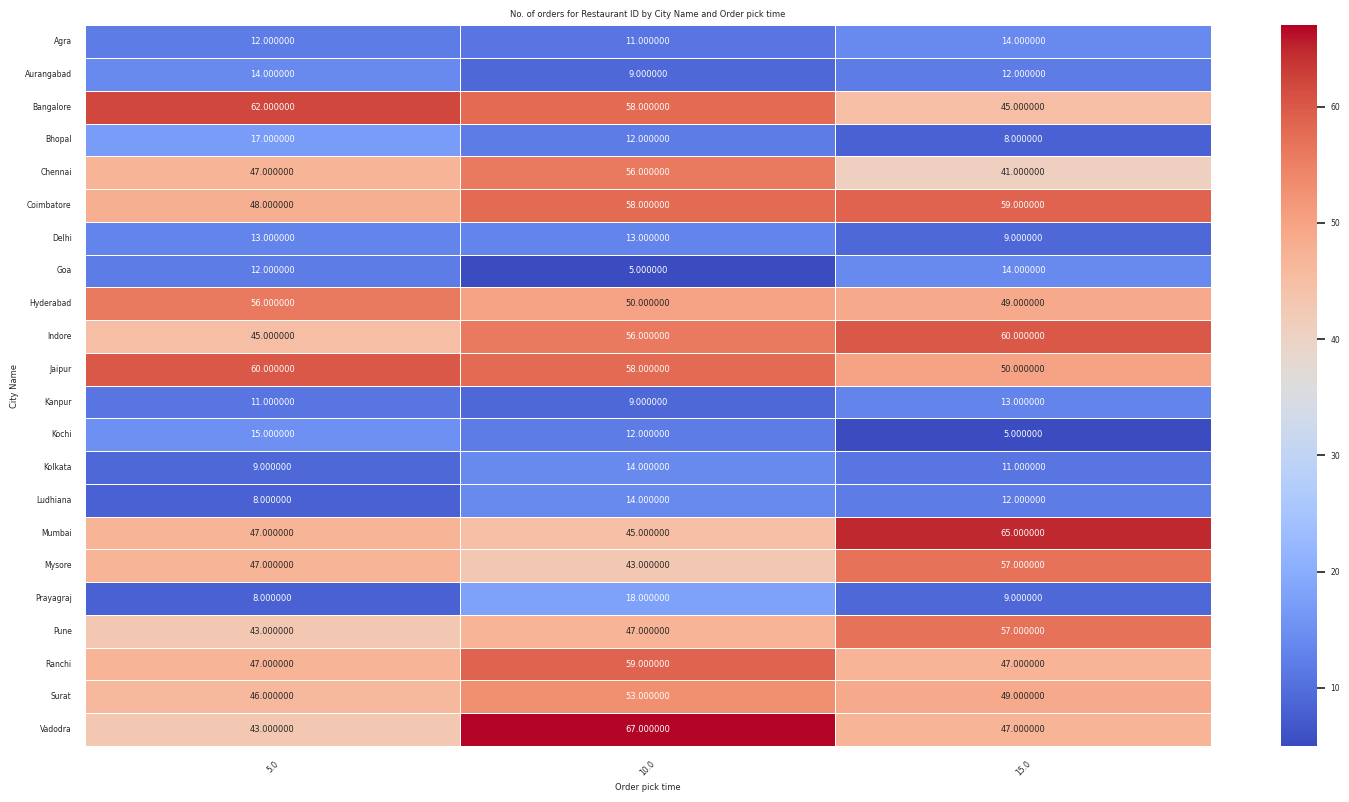

In [1142]:
# Create a pivot table to aggregate counts of weather conditions by city and month
df_cleaned = df.dropna(subset=["order_pick_time"])
order_pick_pivot = (
    df_cleaned.groupby(["city_name", "order_pick_time", "restaurant_id"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Reshape the data for a heatmap-friendly format
heatmap_data = order_pick_pivot.pivot(index="city_name", columns="order_pick_time", values=3)

plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, annot=True, fmt="f", cmap="coolwarm", linewidths=0.5)

plt.title("No. of orders for Restaurant ID by City Name and Order pick time")
plt.xlabel("Order pick time")
plt.ylabel("City Name")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

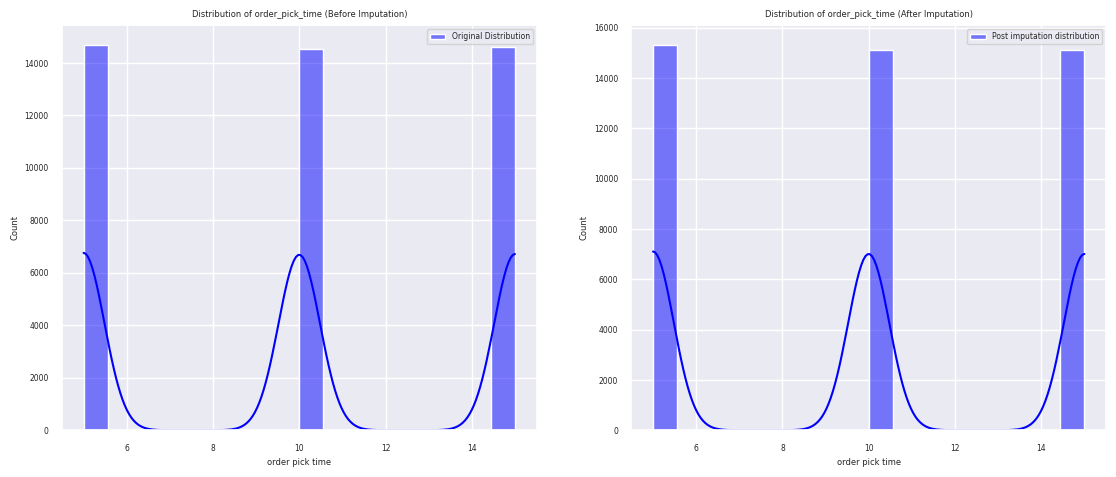

In [1143]:
# Before imputing
plt.figure(figsize=(12, 5))
sns.set(font_scale=0.5)

# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(1,2,1)
sns.histplot(df['order_pick_time'].dropna(), kde=True, color='blue', label='Original Distribution')
plt.title('Distribution of order_pick_time (Before Imputation)')
plt.xlabel('order pick time')
plt.ylabel('Count')
plt.legend()

df['order_pick_time'] = df.groupby(["city_name", "restaurant_id"])['order_pick_time'].transform(lambda x: x.fillna(x.mode()[0]))

# Plot the original distribution of 'road_traffic_density' before imputation
plt.subplot(1,2,2)
sns.histplot(df['order_pick_time'], kde=True, color='blue', label='Post imputation distribution')
plt.title('Distribution of order_pick_time (After Imputation)')
plt.xlabel('order pick time')
plt.ylabel('Count')
plt.legend()

In [1144]:
df['time_orderd'] = np.where(df['time_orderd'].isna(), df['time_order_picked']- pd.to_timedelta(df['order_pick_time'], unit='m'), df['time_orderd'])
df.isna().sum()[df.isna().sum()>0]

,0


### 13. Extracting Day of the week from the order date and if it is a weekend or weekday, as well as if it is a holiday

In [1145]:
df['day_of_week'] = df['order_date'].dt.day_name()
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name,restaurant_id,driver_id,month_ordered,order_pick_time,day_of_week
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore,13,2,3,15.0,Saturday
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore,18,2,3,5.0,Friday


In [1146]:
df['weekend_flag'] = df['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name,restaurant_id,driver_id,month_ordered,order_pick_time,day_of_week,weekend_flag
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore,13,2,3,15.0,Saturday,1
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore,18,2,3,5.0,Friday,0


In [1147]:
df['order_date'].dt.year.unique()

array([2022], dtype=int32)

In [1148]:
indian_holidays = holidays.India(years=[2022])
indian_holidays

{datetime.date(2022, 1, 14): 'Makar Sankranti / Pongal', datetime.date(2022, 1, 26): 'Republic Day', datetime.date(2022, 8, 15): 'Independence Day', datetime.date(2022, 10, 2): 'Gandhi Jayanti', datetime.date(2022, 5, 1): 'Labour Day', datetime.date(2022, 10, 24): 'Diwali', datetime.date(2022, 3, 18): 'Holi', datetime.date(2022, 8, 8): 'Day of Ashura (estimated)', datetime.date(2022, 10, 8): 'Mawlid (estimated)', datetime.date(2022, 5, 2): 'Eid ul-Fitr (estimated)', datetime.date(2022, 5, 3): 'Eid ul-Fitr (estimated)', datetime.date(2022, 7, 9): 'Eid al-Adha (estimated)', datetime.date(2022, 7, 10): 'Eid al-Adha (estimated)', datetime.date(2022, 4, 10): 'Palm Sunday', datetime.date(2022, 4, 15): 'Good Friday', datetime.date(2022, 4, 17): 'Easter Sunday', datetime.date(2022, 6, 5): 'Feast of Pentecost', datetime.date(2022, 12, 25): 'Christmas Day'}

In [1149]:
df['is_holiday'] = df['order_date'].apply(lambda x: 1 if x in indian_holidays else 0)
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name,restaurant_id,driver_id,month_ordered,order_pick_time,day_of_week,weekend_flag,is_holiday
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore,13,2,3,15.0,Saturday,1,0
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore,18,2,3,5.0,Friday,0,0


### 14. Extracting Hour of the day from the Time_Orderd column

In [1150]:
df['hour_of_order'] = df['time_orderd'].dt.hour
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name,restaurant_id,driver_id,month_ordered,order_pick_time,day_of_week,weekend_flag,is_holiday,hour_of_order
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore,13,2,3,15.0,Saturday,1,0,11
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore,18,2,3,5.0,Friday,0,0,19


### 15. Engineering a new feature - order timestamp

In [1224]:
df['order_timestamp'] = df['order_date'].astype(str) + ' ' + df['time_orderd'].astype(str).str.split(' ').str[1]
df['order_timestamp'] = pd.to_datetime(df['order_timestamp'])
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name,restaurant_id,driver_id,month_ordered,order_pick_time,day_of_week,weekend_flag,is_holiday,hour_of_order,distance,order_timestamp
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore,13,2,3,15.0,Saturday,1,0,11,3.025149,2022-03-19 11:30:00
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore,18,2,3,5.0,Friday,0,0,19,20.183530,2022-03-25 19:45:00


### 16. Handling the zero latitude and longitude values of restaurant

In [1161]:
df[df['restaurant_latitude']==0.0].shape

(3640, 28)

In [1162]:
# Assuming `df` is your DataFrame with columns: city, restaurant_number, latitude, longitude
df1 = df.copy()

df1.drop(df[df['restaurant_latitude']==0.0].index, axis=0, inplace=True)

city_means = df1.groupby('city_name')[['restaurant_latitude', 'restaurant_longitude']].mean()

# Impute missing values with city mean
df['restaurant_latitude'] = np.where(df['restaurant_latitude']==0.0, df['city_name'].map(city_means['restaurant_latitude']), df['restaurant_latitude'])
df['restaurant_longitude'] = np.where(df['restaurant_longitude']==0.0, df['city_name'].map(city_means['restaurant_longitude']), df['restaurant_longitude'])

In [1163]:
df[df['restaurant_latitude']==0.0].shape

(0, 28)

In [1164]:
df[df['delivery_location_latitude']<1].shape

(3640, 28)

In [1165]:
df2 = df.copy()

df2.drop(df[df['delivery_location_latitude']<1].index, axis=0, inplace=True)
df2.shape

city_means = df2.groupby('city_name')[['delivery_location_latitude', 'delivery_location_longitude']].mean()

# Impute missing values with city mean
df['delivery_location_latitude'] = np.where(df['delivery_location_latitude']<1, df['city_name'].map(city_means['delivery_location_latitude']),
                                            df['delivery_location_latitude'])
df['delivery_location_longitude'] = np.where(df['delivery_location_longitude']<1, df['city_name'].map(city_means['delivery_location_longitude']),
                                            df['delivery_location_longitude'])

In [1166]:
df[df['delivery_location_latitude']<1].shape

(0, 28)

### 17. Calculating the Haversine distance matrix

In [1167]:
# Haversine distance function (using numpy for CPU operations)
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate Haversine distance between two points (in kilometers).
    lat1, lon1, lat2, lon2 are pandas Series or numpy arrays.
    """
    R = 6371.0  # Radius of Earth in kilometers

    # Convert degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Haversine formula
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

# Function to apply haversine distance to a DataFrame (using Dask)
def calculate_haversine(df):
    lat1 = df['lat1']
    lon1 = df['lon1']
    lat2 = df['lat2']
    lon2 = df['lon2']

    # Apply the haversine function and return the result
    return haversine(lat1, lon1, lat2, lon2)

In [1170]:
client = Client()

# Set the logging level to WARNING for the 'distributed' logger
logging.getLogger('distributed').setLevel(logging.WARNING)

latitudes1 = df['restaurant_latitude']
longitudes1 = df['restaurant_longitude']
latitudes2 = df['delivery_location_latitude']
longitudes2 = df['delivery_location_longitude']

# Create a Pandas DataFrame
df1 = pd.DataFrame({
    'lat1': latitudes1,
    'lon1': longitudes1,
    'lat2': latitudes2,
    'lon2': longitudes2
})

dask_df = dd.from_pandas(df1, npartitions=8)

distances = dask_df.map_partitions(calculate_haversine)

tic = time.perf_counter()
distances_computed = distances.compute()
toc = time.perf_counter()

print(f"Time taken: {(toc - tic)} seconds")
# Show the result (for the first 10 distances)
print(distances_computed[:10])

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:42067
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:43373/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:46375'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39661'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:38505', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:38505
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:46886
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45953', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45953
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:46892
INFO:distributed.scheduler:Receive 

Time taken: 0.9789517839999462 seconds
0     3.025149
1    20.183530
2     1.552758
3     7.790401
4     6.210138
5     4.610365
6    16.600361
7    20.205253
8    19.975520
9    10.280582
dtype: float64


In [1171]:
df['distance'] = distances_computed
df.head()

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name,restaurant_id,driver_id,month_ordered,order_pick_time,day_of_week,weekend_flag,is_holiday,hour_of_order,distance
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore,13,2,3,15.0,Saturday,1,0,11,3.025149
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore,18,2,3,5.0,Friday,0,0,19,20.183530
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,1900-01-01 08:30:00,1900-01-01 08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,Bangalore,19,1,3,15.0,Saturday,1,0,8,1.552758
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,1900-01-01 18:00:00,1900-01-01 18:10:00,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,Coimbatore,13,2,4,10.0,Tuesday,0,0,18,7.790401
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,1900-01-01 13:30:00,1900-01-01 13:45:00,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,Chennai,12,1,3,15.0,Saturday,1,0,13,6.210138


## **Exploratory Data Analysis**

### 1. Identifying peak demand times

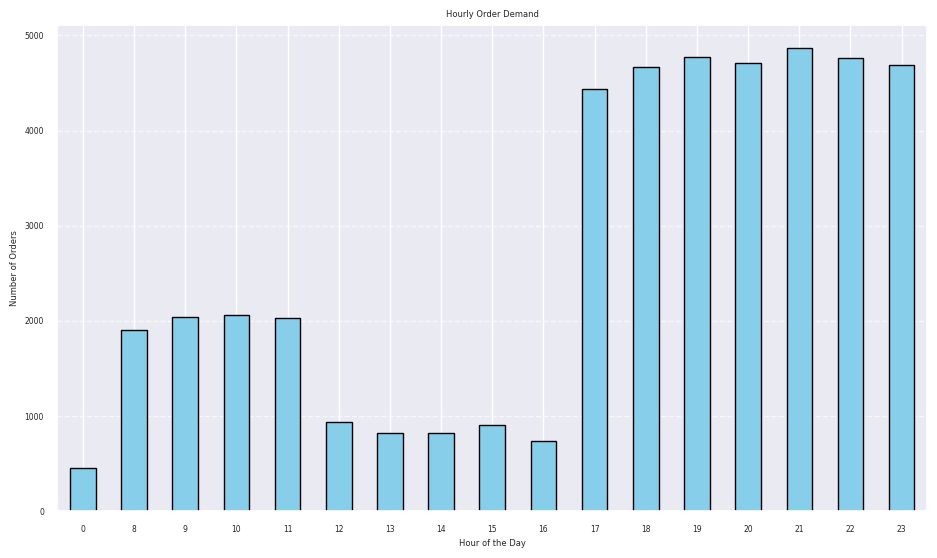

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by hour to find peak demand times
hourly_demand = df.groupby('hour_of_order')['delivery_person_id'].count()

# Plot hourly demand
plt.figure(figsize=(10, 6))
hourly_demand.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Hourly Order Demand')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 2. Weekly demand pattern

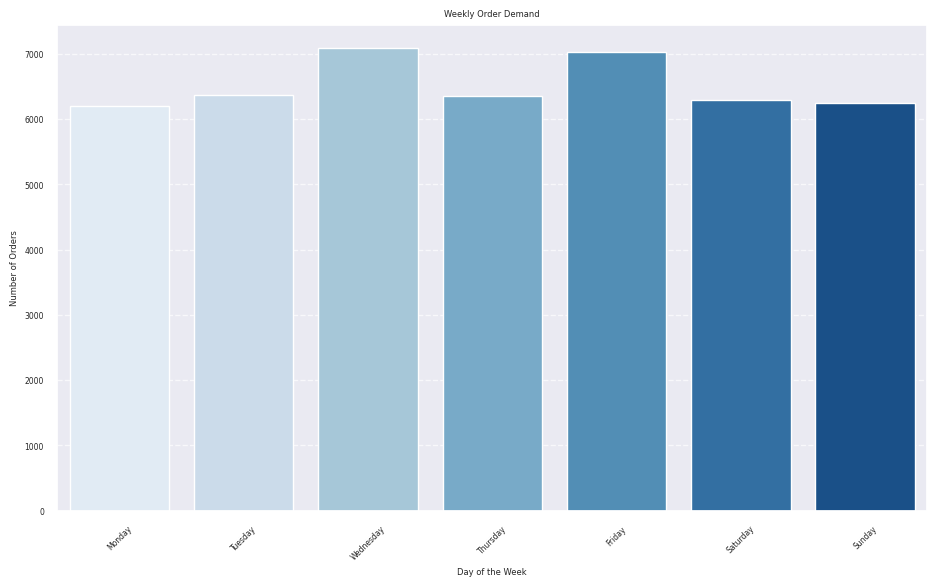

In [ ]:
# Group by day of the week to find trends
weekly_demand = df.groupby('day_of_week')['delivery_person_id'].count()

# Order days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_demand = weekly_demand.reindex(day_order)

# Plot weekly demand
plt.figure(figsize=(10, 6))
sns.barplot(x=weekly_demand.index, y=weekly_demand.values, palette='Blues')
plt.title('Weekly Order Demand')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 3. Daily order demand

In [ ]:
df['order_date'].value_counts().reset_index().sort_values(by='order_date')

,order_date,count
28,2022-02-11,970
40,2022-02-12,864
36,2022-02-13,957
43,2022-02-14,851
37,2022-02-15,945
41,2022-02-16,861
39,2022-02-17,939
42,2022-02-18,855
14,2022-03-01,1140
18,2022-03-02,1012


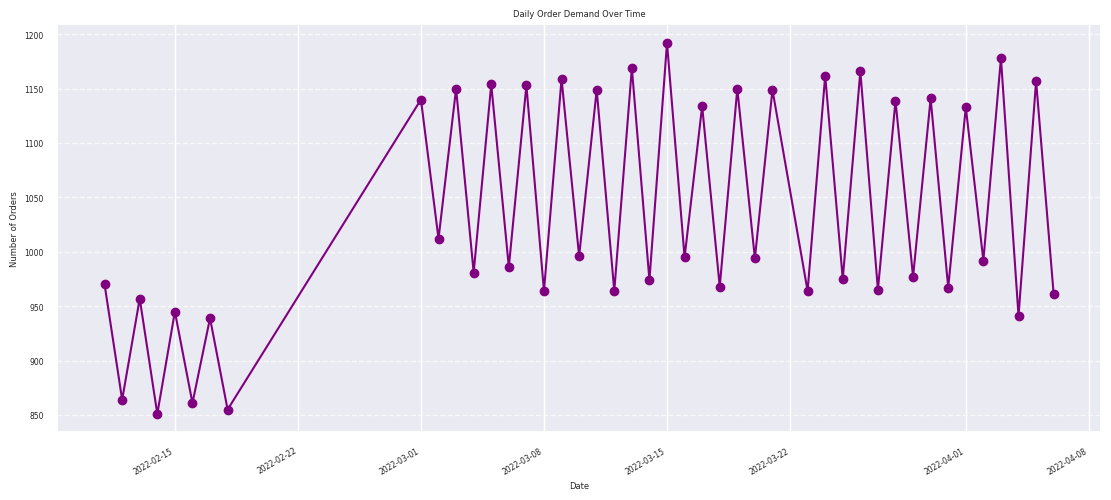

In [ ]:
# Aggregate orders by date
daily_demand = df.groupby('order_date')['delivery_person_id'].count()

# Plot time series
plt.figure(figsize=(12, 6))
daily_demand.plot(marker='o', linestyle='-', color='purple')
plt.title('Daily Order Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 4. Heatmap for Spatial-Temporal Patterns

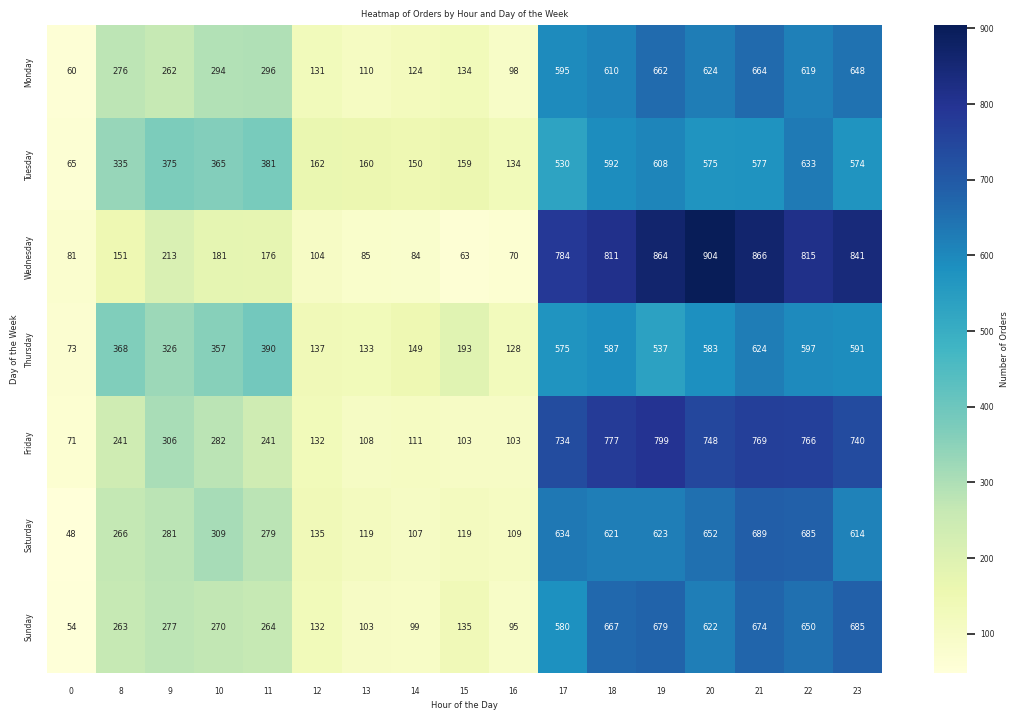

In [ ]:
# Create a pivot table
heatmap_data = df.pivot_table(index='day_of_week', columns='hour_of_order', values='delivery_person_id', aggfunc='count', fill_value=0)

# Reorder day index
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(day_order)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Number of Orders'})
plt.title('Heatmap of Orders by Hour and Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()

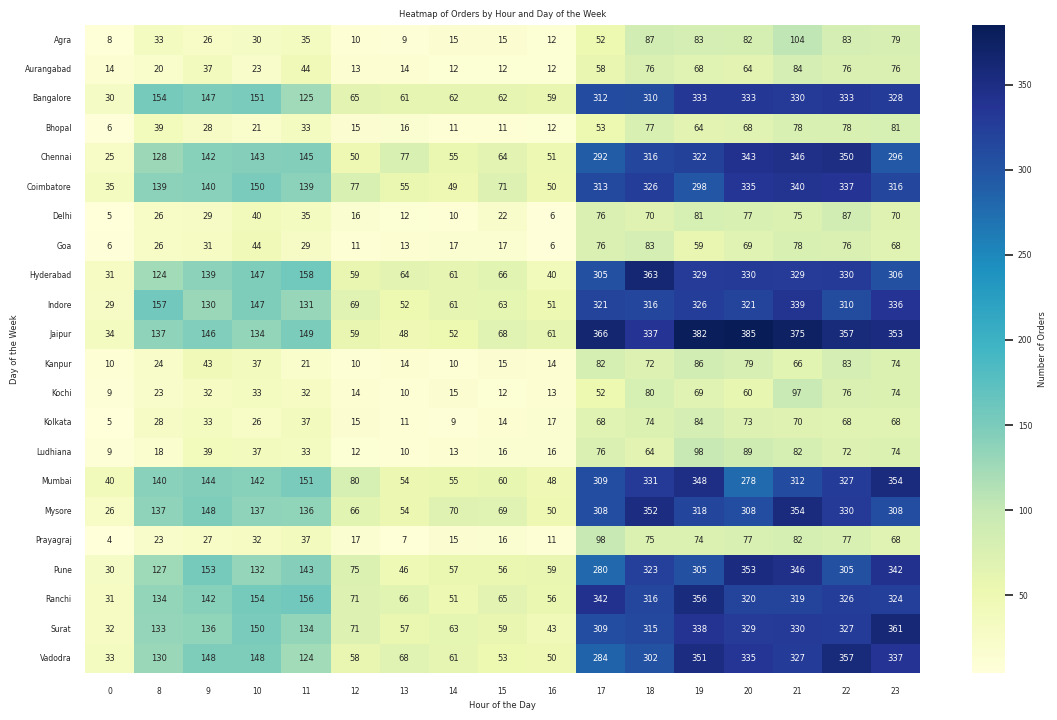

In [1225]:
# Create a pivot table
heatmap_data = df.pivot_table(index='city_name', columns='hour_of_order', values='delivery_person_id', aggfunc='count', fill_value=0)

# Reorder day index
# day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# heatmap_data = heatmap_data.reindex(day_order)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Number of Orders'})
plt.title('Heatmap of Orders by Hour and Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()

### 5. Correlation matrix

In [1201]:
num_cols

['delivery_location_longitude',
 'time_taken_in_mins',
 'delivery_person_ratings',
 'restaurant_longitude',
 'delivery_location_latitude',
 'restaurant_latitude',
 'delivery_person_age']

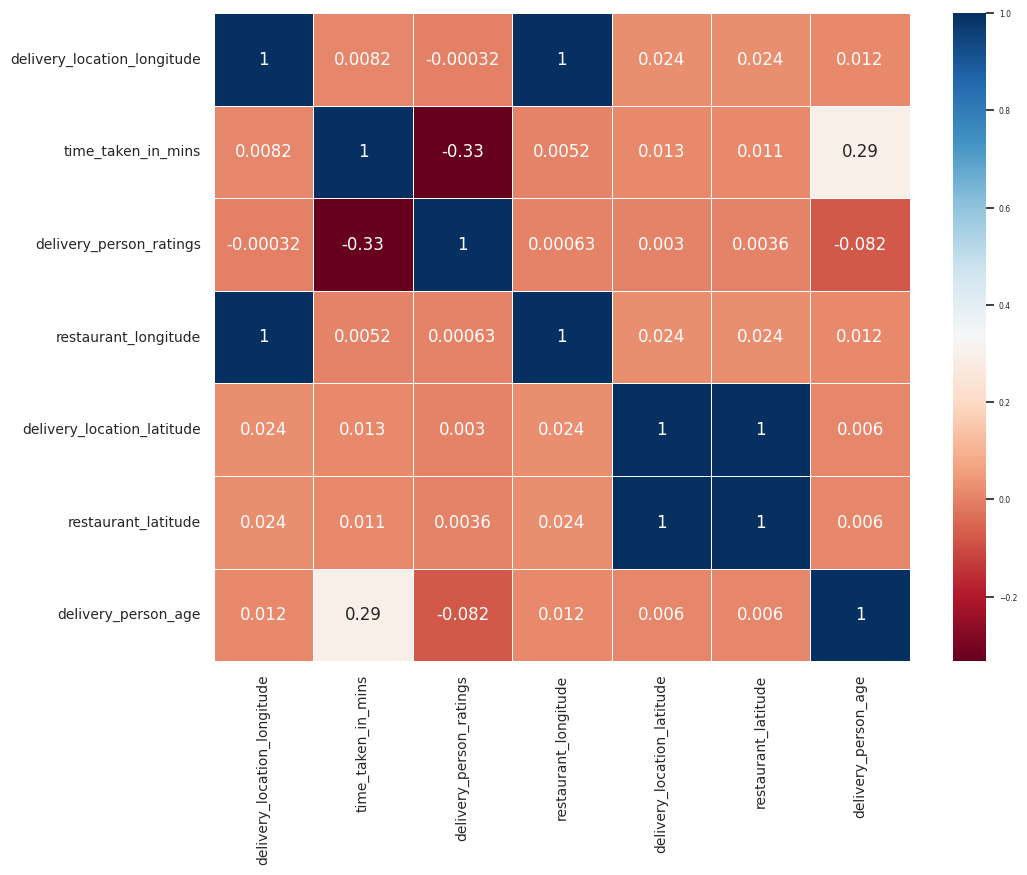

In [1202]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

correlation_matrix(df, num_cols)

In [1226]:
df.head(2)

,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,time_order_picked,weather_conditions,road_traffic_density,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken_in_mins,city_name,restaurant_id,driver_id,month_ordered,order_pick_time,day_of_week,weekend_flag,is_holiday,hour_of_order,distance,order_timestamp
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,1900-01-01 11:30:00,1900-01-01 11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,Indore,13,2,3,15.0,Saturday,1,0,11,3.025149,2022-03-19 11:30:00
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,1900-01-01 19:45:00,1900-01-01 19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,Bangalore,18,2,3,5.0,Friday,0,0,19,20.183530,2022-03-25 19:45:00


### Creating lag features

In [1255]:
df2 = df.groupby(['city_name', 'order_date', 'hour_of_order'])['delivery_person_id'].count().reset_index()
df2.columns = ['city_name', 'order_date', 'hour_of_order', 'order_count']
# Sort data by city and timestamp
df2 = df2.sort_values(by=['city_name', 'order_date', 'hour_of_order']).reset_index(drop=True)

In [1256]:
df2.shape

(6154, 4)

In [1257]:
df2.head()

,city_name,order_date,hour_of_order,order_count
0,Agra,2022-02-11,8,9
1,Agra,2022-02-11,9,8
2,Agra,2022-02-11,10,11
3,Agra,2022-02-11,11,3
4,Agra,2022-02-11,12,3


In [1258]:
# Create lag features for each city
df2['lag_1'] = df2.groupby('city_name')['order_count'].shift(1)  # Demand 1 hour ago
df2['lag_2'] = df2.groupby('city_name')['order_count'].shift(2)  # Demand 2 hours ago
df2['lag_3'] = df2.groupby('city_name')['order_count'].shift(3)  # Demand 3 hours ago

# Fill missing values introduced by shift
df2.fillna(0, inplace=True)

# Display the data with lag features
df2.head(10)

,city_name,order_date,hour_of_order,order_count,lag_1,lag_2,lag_3
0,Agra,2022-02-11,8,9,0.0,0.0,0.0
1,Agra,2022-02-11,9,8,9.0,0.0,0.0
2,Agra,2022-02-11,10,11,8.0,9.0,0.0
3,Agra,2022-02-11,11,3,11.0,8.0,9.0
4,Agra,2022-02-11,12,3,3.0,11.0,8.0
5,Agra,2022-02-11,13,4,3.0,3.0,11.0
6,Agra,2022-02-11,14,3,4.0,3.0,3.0
7,Agra,2022-02-11,15,3,3.0,4.0,3.0
8,Agra,2022-02-11,16,2,3.0,3.0,4.0
9,Agra,2022-02-11,17,5,2.0,3.0,3.0


In [1251]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

# Define features and target variable
X = df2[['city_name', 'lag_1', 'lag_2', 'lag_3']]  # Features
y = df2['order_count']  # Target variable

# Encode city_name (categorical) using one-hot encoding
categorical_features = ['city_name']
numeric_features = ['lag_1', 'lag_2', 'lag_3']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ])

# Create a pipeline with preprocessor and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.5800613621543904


**DBSCAN trial**

In [1172]:
# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt

# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

In [1185]:
df.groupby('city_name')['delivery_person_id'].count().sort_values()

,delivery_person_id
city_name,
Bhopal,691
Kolkata,700
Kochi,701
Aurangabad,703
Goa,709
Delhi,737
Prayagraj,740
Kanpur,740
Ludhiana,758


In [1186]:
df_gps = pd.DataFrame()
df_city = df[df['city_name']=='Jaipur']
df_gps['lat'] = df_city['restaurant_latitude'].values
df_gps['lon'] = df_city['restaurant_longitude'].values
df_gps.head()

,lat,lon
0,26.849596,75.800512
1,26.888420,75.800689
2,26.913987,75.752891
3,26.913483,75.803139
4,26.891191,75.802083


In [1187]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [1188]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

In [1189]:
def dbscan_reduce(df, epsilon, x='lon', y='lat'):
    start_time = time.time()
    # represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
    coords = df[[y, x]].to_numpy()
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters: {:,}'.format(num_clusters))

    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

    # find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({x:lons, y:lats})
    rep_points.tail()

    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.apply(lambda row: df[(df[y]==row[y]) & (df[x]==row[x])].iloc[0], axis=1)

    # all done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:.2f}% compression in {:,.2f} seconds.'
    print(message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)), time.time()-start_time))
    return rs

In [1195]:
# first cluster the full gps location history data set coarsely, with epsilon=5km in radians
eps_rad = 3 / kms_per_radian
df_clustered = dbscan_reduce(df_gps, epsilon=eps_rad)

Number of clusters: 5
Clustered 3,443 points down to 5 points, for 99.85% compression in 0.49 seconds.


In [1196]:
# next, sample every nth row (where n=sample_rate) of the full gps location history data set
sample_rate = 20
df_sampled = df_gps.iloc[range(0, len(df_gps), sample_rate)]
len(df_sampled)

173

In [1197]:
# combine the clustered and sampled sets
df_combined = pd.concat([df_clustered, df_sampled], axis=0)
df_combined = df_combined.reset_index().drop(labels='index', axis=1)

In [1198]:
# then reduce by clustering again, finely this time with epsilon=0.1km in radians
eps_rad = 0.1 / kms_per_radian
df_final = dbscan_reduce(df_combined, epsilon=eps_rad)

Number of clusters: 18
Clustered 178 points down to 18 points, for 89.89% compression in 0.06 seconds.


In [1199]:
# save to csv
df_final.to_csv('data/location-history-clustered.csv', index=False, encoding='utf-8')

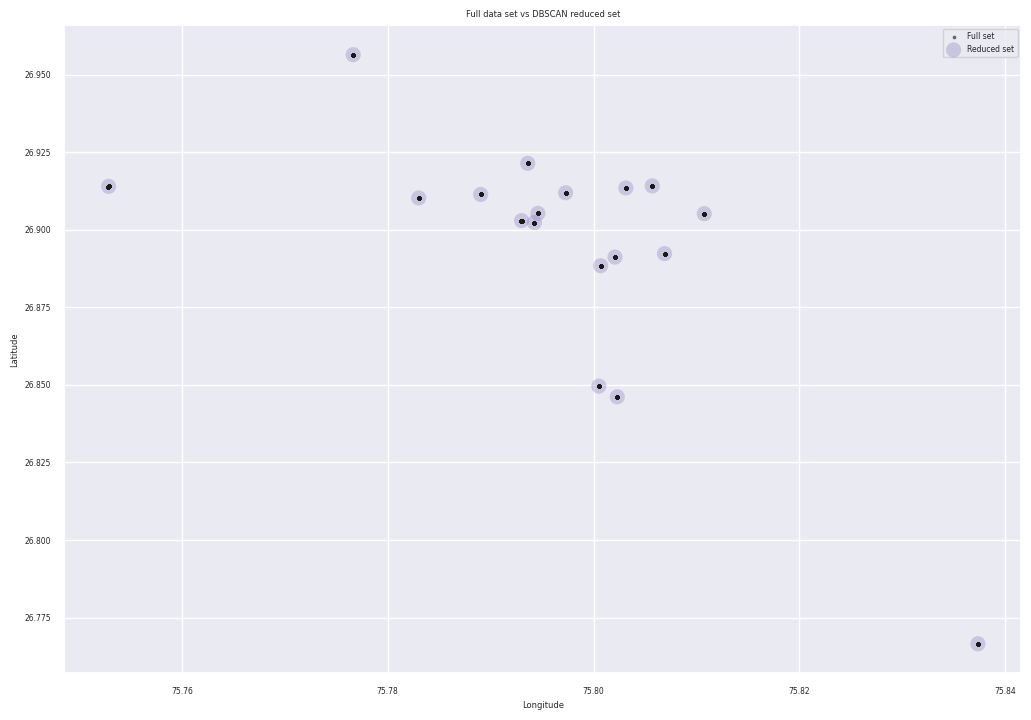

In [1200]:
# show a map of the worldwide data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_final['lon'], df_final['lat'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df_gps['lon'], df_gps['lat'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

## **Modularization**

In [ ]:
data = pd.read_csv('/content/data/train.csv')
data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


### 1. Column dropper class

In [ ]:
class ColumnDropper(BaseEstimator, TransformerMixin):

    def __init__(self, col_list: list):

        if not isinstance(col_list, list):
            raise ValueError("Columns should be a list of strings")

        self.col_list = col_list

    def fit(self, dataframe = pd.DataFrame, target: pd.Series = None):

        return self

    def transform(self, dataframe = pd.DataFrame, target: pd.Series = None):

        df = dataframe.copy()
        df.drop(columns=self.col_list,inplace=True)

        return df

In [ ]:
col_dropper = ColumnDropper(['ID'])

data = col_dropper.fit_transform(data)
data.head()

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [ ]:
class Mapper(BaseEstimator, TransformerMixin):
    """
    Ordinal categorical variable mapper:
    Treat column as Ordinal categorical variable, and assign values accordingly
    """

    def __init__(self, col_map: dict):

        if not isinstance(col_map, dict):
            raise ValueError("Mappings should be a dictionary of col, strings pair")
        self.col_map = col_map

    def fit(self, dataframe: pd.DataFrame, target: pd.Series = None):

        return self

    def transform(self, dataframe: pd.DataFrame):

        df = dataframe.copy()

        for key, val in self.col_map.items():
            df[key] = df[key].map(val)

        return df

In [ ]:
mapping_dict = {
"weather_mappings": {
                        "Sunny": 0,
                        "Stormy": 1,
                        "Sandstorms": 2,
                        "Cloudy": 3,
                        "Fog": 4,
                        "Windy": 5
                    }

"traff_den_mappings": {
                        "High": 0,
                        "Jam": 1,
                        "Low": 2,
                        "Medium": 3
                    }

"order_type_mappings": {
                        "Snack": 0,
                        "Drinks": 1,
                        "Buffet": 2,
                        "Meal": 3
                    }

"vehicle_mappings": {
                        "motorcycle": 0,
                        "scooter": 1,
                        "electric_scooter": 2,
                        "bicycle": 3
                    }

"festival_mappings": {
                        "No": 0,
                        "Yes": 1
                    }

"city_area_mappings": {
                        "Urban": 0,
                        "Metropolitian": 1,
                        "Semi-Urban": 2
                    }

"city_mappings":  {
                    "INDO": 0,
                    "BANG": 1,
                    "COIMB": 2,
                    "CHEN": 3,
                    "HYD": 4,
                    "RANCHI": 5,
                    "MYS": 6,
                    "DEH": 7,
                    "KOC": 8,
                    "PUNE": 9,
                    "LUDH": 10,
                    "KNP": 11,
                    "MUM": 12,
                    "KOL": 13,
                    "JAP": 14,
                    "SUR": 15,
                    "GOA": 16,
                    "AURG": 17,
                    "AGR": 18,
                    "VAD": 19,
                    "ALH": 20,
                    "BHP": 21
                }

clmapper = Mapper(mapping_dict)
data = clmapper.fit_transform(data)
data.head()

In [ ]:
data.head()

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30
